# State lumping with rewards

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")
library(repr)
options(repr.plot.width=8, repr.plot.height=5.5)

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a local remote, the SHA1 (1.0.0) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
# Rcpp::sourceCpp("./cpp/timeinhom-kingman.cpp")

# Plotting

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [10]:
# get_cov_mat <- function(graph, rewards) {
#     n <- nrow(rewards)
#     cov_mat <- matrix(nrow=n,ncol=n)
#     for (i in 1:(n)) {
#         for (j in 1:(n)) {
#             cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
#         }
#     }
#     return(cov_mat)
# }
                  
# plot_cov_mat <- function(cov_mat) {
   
#     df <- as.data.frame(cov_mat)
#     df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
#     df$ton1 <- as.character(df$ton1)
#     df$ton2 <- gsub("V","",as.character(df$ton2))
#     df$ton1 <- factor(df$ton1, levels=unique(df$ton1[order(as.numeric(df$ton1))]))
#     df$ton2 <- factor(df$ton2, levels=unique(df$ton2[order(as.numeric(df$ton2))]))
    
#     ggplot(df, aes(ton1, ton2)) +
#         geom_tile(aes(fill = value)) + 
#         scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
#         scale_fill_continuous(type = "viridis") + 
#         theme_minimal() + 
#         theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

# }

# Graph construction

## Coalescent

In [11]:
standard_coalescent <- function(n) {
    
    # n <- 4
      
    state_vector_length <- n
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- rep(0, n)
    initial_state[1] <- n
    
    add_edge(
      starting_vertex,
      create_vertex(graph, initial_state),
      1
    )
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)  
        
      # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state
          
          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }
          
          # copy state
          child_state <- state
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
          
      index <- index + 1
    }
    return(graph)
}
# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

## Two-locus ARG

In [12]:
Rcpp::sourceCpp("./cpp/index_prop_mapping.cpp")

In [13]:
               
construct_arg <- function(s, N, R) {

    # state vector length
    n <- (s+1)**2

    graph <- create_graph(n)
    index <- 1
    # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
    state <- rep(0, n)
    state[props_to_index_two_locus(s, 1, 1, 1)] <- s
    first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
    add_edge(starting_vertex(graph), first_vertex, 1)

    index <- 2
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state

      count <- 0
      for (i in 1:n) {
          count <- count + state[i]
      }
      if (count <= 1) {
          # Only one lineage, stop
          index <- index + 1
          next
      }    

      for (i in 1:n) {
        if (state[i] == 0) next

        conf_i <- index_to_props_two_locus(s, i)

        # coalescence #########################
        for (j in i:n) {
          if (state[j] == 0) next
            
          conf_j <- index_to_props_two_locus(s, j)

          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            rate <- state[i] * (state[i] - 1) / 2 / N
          } else {
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            rate <- state[i] * state[j] / N
          }

          child_state <- state
        
          # lineages with index i and j coalesce:  
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
          stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)

          # coalescene into lineage with index k
          k = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
          child_state[k] <- child_state[k] + 1

          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)

        }
        

        # recombination #######################
        if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {

          rate <- R #* state[i] 
          child_state <- state

          # a lineage with index i recombines to produce lineages with index k and l
          k = props_to_index_two_locus(s, conf_i$descendants_l1, 0)
          l = props_to_index_two_locus(s, 0, conf_i$descendants_l2)
          child_state[i] <- child_state[i] - 1
          child_state[k] <- child_state[k] + 1
          child_state[l] <- child_state[l] + 1
            
          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)
        }

      }

      index <- index + 1

      # if ((index %% 50) == 0) {
      #   cat(index, vertices_length(graph), "\n")
      # }

    }
    
    return(graph)
}

## Rabbits

In [14]:
construct_rabbits <- function(number_of_rabbits, flooding_rate_l, flooding_rate_r) {
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length <- 2
    graph <- create_graph(state_vector_length)
    initial_state <- c(number_of_rabbits, 0)
    # The initial state is the only starting state, with 100% starting probability
    add_edge(
      starting_vertex(graph),
      find_or_create_vertex(graph, initial_state),
      1
    )
    index <- 2
    # Iterate over all unvisited vertices
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] > 0) {
        # Rabbit jump left to right
        child_state <- c(state[1] - 1, state[2] + 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )

        # Left island flooding
        child_state <- c(0, state[2])
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_l
        )
      }

      if (state[2] > 0) {
        # Rabbit jump right to left
        child_state <- c(state[1] + 1, state[2] - 1)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          1
        )
        # Right island flooding with rate of 4
        child_state <- c(state[1], 0)
        add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          flooding_rate_r
        )
      }
      index <- index + 1
    }
    return(graph)
}

## Utilities

In [15]:
not_start_or_abs <- function(graph) {
    fun <- function(i) {
        vertex <- vertex_at(graph, i)
        if (vertex$index != starting_vertex(graph)$index && length(edges(vertex)) > 0) {
            return(TRUE)
        }
        return(FALSE)
    }
    return(sapply(1:vertices_length(new_graph), fun))
}    

# Create graph

In [16]:
model <- "ARG"
# model <- "Coalescent"
# model <- "Rabbits"

## Coalescent

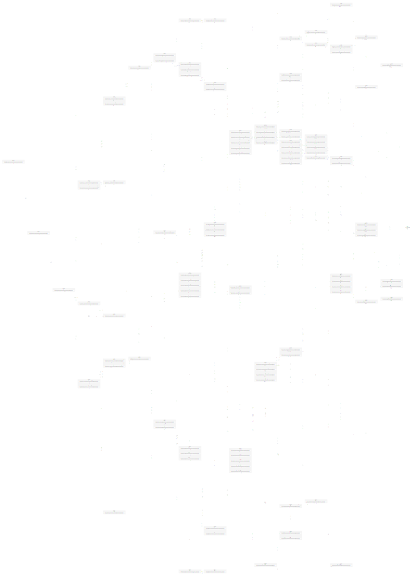

In [166]:
if (model == "Coalescent") {

    sample_size <- 4
    
    map_state <- function(state) {
        # lumped_state <- state
        # lumped_state <- rep(sum(state), 10)
        # lumped_state <- sum(state)
        lumped_state <- as.integer(lumped_state)


        return(state)
        # return(rep(sum(state), 10))
    }
    label_fun <- function(state, index) {
        return(paste(map_state(state), collapse=""))
    }
    
    graph <- standard_coalescent(sample_size)
    
    gam <- graph_as_matrix(graph)
    #gam
    
    plot_graph(gam, size=c(12, 8), align=TRUE, rainbow=TRUE,
                   fontsize=15, ranksep=1, nodesep=1, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
               splines='line'
              )
}
if (model == "ARG") {
    
    sample_size <- 4
    
    map_state <- function(state)
    {
        # # TODO: sample_size THIS SHOULD BE GIVEN TO THE FUNCTION...
        
        lumped_state <- c(0, 0, 0)
        for (i in 1:length(state)) {
            props <- index_to_props_two_locus(sample_size, i)        
            lumped_state[1] <- lumped_state[1] + state[i] * as.logical(props$descendants_l1)
            lumped_state[2] <- lumped_state[2] + state[i] * as.logical(props$descendants_l2)
            lumped_state[3] <- lumped_state[3] + state[i] * min(props$descendants_l1, props$descendants_l2)
        }
        lumped_state <- as.integer(lumped_state)
        return(lumped_state)

        # return(state)

    }
    label_fun <- function(state, index)
    {
        return(paste(map_state(state), collapse=""))
    }
    
    # graph <- construct_arg(sample_size, 1, 100000)
    graph <- construct_arg(sample_size, 1, 3)
    gam <- graph_as_matrix(graph)

    plot_graph(gam, size=c(12, 8), align=TRUE, rainbow=TRUE,
                   fontsize=15, ranksep=1, nodesep=1, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
               splines='line'
              )
    
}

if (model == "Rabbits") {

    rabbits <- 2
    
    map_state <- function(state) {
        # return(sum(state))
        return(state)
        # return(state[1])
    }
    label_fun <- function(state, index) {
        return(paste(map_state(state), collapse=""))
    }
    
    graph <- construct_rabbits(rabbits, 0.1, 0.1)    
    gam <- graph_as_matrix(graph)
    #gam
    
    plot_graph(gam, size=c(12, 8), align=TRUE, rainbow=TRUE,
                   fontsize=15, ranksep=1, nodesep=1, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
               splines='line'
              )
}

## matrix -> graph -> matrix

To make sure vertex/state indicies match up between graph and matrix version ...

In [167]:
graph <- matrix_as_graph(gam$IPV, gam$SIM, gam$states)
gam <- graph_as_matrix(graph)
gam

0,4,0,0,0,4,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,3,0,0,0,3,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,2,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,1,3,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,3,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,2,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,2,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,2,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,1,0,0,3,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,1,0,0,4,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## State Lumping

A valid lumping assumes that:

- The relative contribution of original states to rewards of new lumped states is only determined by the number of equivalent ways each state can be produced (computed by multinom below).

Compute rate matrix $\mathbf{P}$ including absorbing state:

In [168]:
gam <- graph_as_matrix(graph)

P <- rbind(cbind(gam$SIM, -rowSums(gam$SIM)), 0)
P[nrow(P), ncol(P)] <- 1
diag(P) <- 0
P

0,16,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,9,0,0,3,0,0,0,3,⋯,0,0,0,0,0,0,0,0,0,0
0,3,0,4,0,0,4,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,3,0,1,0,0,3,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,3,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,6,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,3,0,2,0,3,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,3,0,3,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,2,0,3,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,3,0,3,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,4,0,0,0,8,⋯,0,0,0,0,0,0,0,0,0,0


Augment state matrix to include absorbing (add a row and column for absorbing state):

Add first col and last row corresponding to start and abs states

In [169]:
states <- rbind(gam$states, 0)
# states <- cbind(0, rbind(gam$states, 0))
states

0,4,0,0,0,4,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,3,0,0,0,3,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,2,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,1,3,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,4,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,0,0,0,3,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,2,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,2,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,2,2,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,1,0,0,3,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,2,1,0,0,4,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Compute $\mathbf{V}$ defining lumping. Columns represent lumped states and rows represent contributing states:

In [170]:
new_state_len <- length(map_state(states[1, ]))
# new_states <- as.matrix(t(apply(states, 1, map_state)))
new_states <- matrix(apply(states, 1, map_state), ncol=new_state_len, byrow=TRUE)
new_states

4,4,0
4,4,1
4,4,2
4,4,3
4,4,4
3,4,1
3,4,2
3,4,3
3,4,2
3,4,1
3,4,0


In [171]:
V <- sapply(1:nrow(states), function(i) as.integer(apply(new_states, 1, function(x) all(x == new_states[i, ]))))
dups <- duplicated(V, MARGIN=2)            
V <- V[, !dups]            
V 

1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


Compute new state matrix for the lumped non-absorbing states. Rows are state vectors.

In [172]:
new_state_len <- length(map_state(states[1, ]))
new_states <- as.matrix(new_states[!dups, ])
new_states

4,4,0
4,4,1
4,4,2
4,4,3
4,4,4
3,4,1
3,4,2
3,4,3
3,4,0
4,3,1
4,3,2


Compute $\mathbf{U}$: Normalization to produce mean rates for each lumped state. (not Green matrix...)

In [173]:
U <- t(V) / colSums(V) # not green matrix...
U

1,0,0,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,1,0,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,1,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,1,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,1,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.5,0.0,0,0.0,0.5,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.0,0.5,0,0.5,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.0,0.0,1,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0
0,0,0,0,0,0.0,0.0,0,0.0,0.0,⋯,0,0.0,0,0.0,0,0,0.0,0,0,0


Compute rate matrix for new lumped chain as $\mathbf{U}\mathbf{P}\mathbf{V}$:

In [174]:
m <- U %*% P %*% V

Turn it into the new subintensity matrix $\mathbf{S}'$

In [175]:
diag(m) <- -rowSums(m)
new_sim <- m[-nrow(m), -ncol(m)]
new_sim

-28,16,0,0,0,0.0,0.0,0,6,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
3,-24,9,0,0,6.0,0.0,0,0,6.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,3,-18,4,0,0.0,5.0,0,0,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,3,-13,1,0.0,0.0,3,0,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,3,-9,0.0,0.0,0,0,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,-18.0,6.0,0,3,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,4.5,-14.5,2,0,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,0.0,6.0,-12,0,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,12.0,0.0,0,-21,0.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,0.0,0.0,0,0,-18.0,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0
0,0,0,0,0,0.0,0.0,0,0,4.5,⋯,0.00,0,0.0,0.0,0.0000000,0,0.0,0.0000000,0.0,0


In [176]:
new_gam_states <- as.matrix(new_states[-nrow(new_states), ]) 
new_gam_states

4,4,0
4,4,1
4,4,2
4,4,3
4,4,4
3,4,1
3,4,2
3,4,3
3,4,0
4,3,1
4,3,2


Compute new initial probability vector $\mathbf{\alpha}'$:

In [177]:
# new_ipv <- c(0, gam$IPV, 0)[!dups][c(2:new_state_len)]
new_ipv <- c(gam$IPV, 0)[!dups][1:nrow(new_sim)]
new_ipv

[1] 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Construct the new lumped graph from matrices:

In [178]:
new_graph <- matrix_as_graph(new_ipv, new_sim, new_gam_states)
#new_graph <- matrix_as_graph(new_ipv, new_sim, new_states)
new_gam <- graph_as_matrix(new_graph)
new_gam

4,4,0
4,4,1
4,4,2
4,4,3
4,4,4
3,4,3
3,4,2
3,4,1
3,4,0
4,3,3
4,3,2


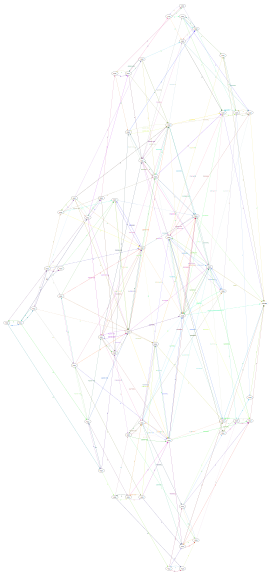

In [179]:
plot_graph(graph_as_matrix(new_graph), size=c(12, 8), align=TRUE, rainbow=TRUE,
               fontsize=15, ranksep=1, nodesep=1, rankdir="LR",# subgraphs=TRUE, subgraphfun=label_fun, 
           splines='line'
          )

## Rewards

Compute rewards so lumped graph accumulate rewards like the original graph:

In [180]:
multinom <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom(params[-length(params)]))
}

weights <- apply(states, 1, multinom)

v <- t(t(V * weights) / colSums(V * weights))

new_reward_matrix <- sapply(1:ncol(v), function(i) colSums(states * v[, i]))    
new_reward_matrix <- new_reward_matrix[rowSums(new_reward_matrix) != 0, ] # to remove states collapsed into others in new graph
new_reward_matrix <- cbind(0, new_reward_matrix)

new_graph_states <- as.matrix(states(new_graph))
new_states <- rbind(as.integer(0), new_states)                            
sort_idx <- match(data.frame(t(new_states)), data.frame(t(new_graph_states)))  

new_reward_matrix <- new_reward_matrix[, sort_idx]
new_reward_matrix

0,4,3,2,1,0,1.3333333,0.6666667,0,2,⋯,0.0000000,0,0,0,0.6666667,0,1,0,0,0
0,0,0,0,0,0,0.6666667,0.3333333,0,1,⋯,0.0000000,0,0,0,0.6666667,1,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.6666667,0,0,1,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,1.0000000,0,0,0,0.0000000,0,0,0,1,0
0,4,3,2,1,0,3.0000000,2.0000000,1,4,⋯,0.6666667,0,0,1,0.0000000,0,0,0,0,0
0,0,1,2,3,4,0.6666667,1.3333333,2,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.3333333,0.6666667,1,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,1,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.6666667,1,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0


In [181]:
t(rbind(0, new_gam$states, 0)[new_gam$indices, ])

4,4,4,4,4,3,3,3,3,4,⋯,3,1,1,1,1,2,2,2,2,1
4,4,4,4,4,4,4,4,4,3,⋯,1,2,2,2,2,1,1,1,1,1
0,1,2,3,4,1,2,3,0,1,⋯,1,2,0,3,1,2,0,1,3,0


Reward matrix from original graph:

In [182]:
reward_matrix <- as.matrix(t(states(graph)))
#reward_matrix <- reward_matrix[-nrow(reward_matrix), ] # assuming last row is the absorbing state...
reward_matrix

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,4,3,2,1,0,0,1,2,2,⋯,0,0,0,0,0,0,1,1,0,0
0,0,0,0,0,0,1,1,1,0,⋯,0,0,0,2,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,1,0
0,4,3,2,1,0,2,3,4,3,⋯,0,1,1,0,0,0,0,0,0,0
0,0,1,2,3,4,2,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [183]:
cbind(0, t(gam$states), 0)

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,4,3,2,1,0,2,1,0,0,⋯,0,0,0,0,0,1,1,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,2,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,1,0
0,4,3,2,1,0,3,2,1,2,⋯,0,1,1,0,0,0,0,0,0,0
0,0,1,2,3,4,0,1,2,2,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [184]:
cbind(0, t(gam$states), 0) - reward_matrix

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,2,0,-2,-2,⋯,0,0,0,0,0,1,0,-1,0,0
0,0,0,0,0,0,-1,-1,-1,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,-1,0,1,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,-1,-3,-1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,-2,0,2,2,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,1,1,1,-1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Reward matrix for lumped graph:

In [185]:
new_reward_matrix

0,4,3,2,1,0,1.3333333,0.6666667,0,2,⋯,0.0000000,0,0,0,0.6666667,0,1,0,0,0
0,0,0,0,0,0,0.6666667,0.3333333,0,1,⋯,0.0000000,0,0,0,0.6666667,1,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.6666667,0,0,1,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,1.0000000,0,0,0,0.0000000,0,0,0,1,0
0,4,3,2,1,0,3.0000000,2.0000000,1,4,⋯,0.6666667,0,0,1,0.0000000,0,0,0,0,0
0,0,1,2,3,4,0.6666667,1.3333333,2,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.3333333,0.6666667,1,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,1,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.6666667,1,0,0,0.0000000,0,0,0,0,0
0,0,0,0,0,0,0.0000000,0.0000000,0,0,⋯,0.0000000,0,0,0,0.0000000,0,0,0,0,0


In [186]:
rbind(0, new_reward_matrix, 0) - reward_matrix

ERROR: Error in rbind(0, new_reward_matrix, 0) - reward_matrix: non-conformable arrays


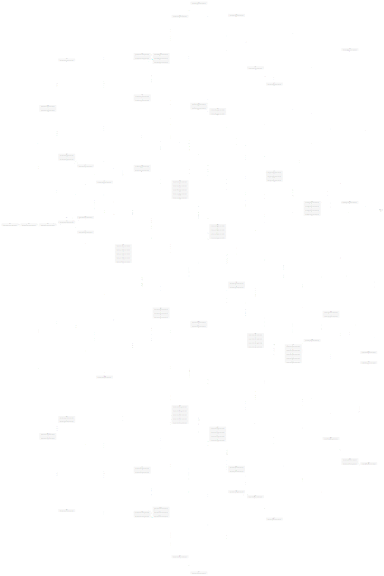

In [187]:
plot_graph(gam, size=c(12, 8), align=TRUE, rainbow=TRUE,
               fontsize=15, ranksep=1, nodesep=1, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
           splines='line'
          )

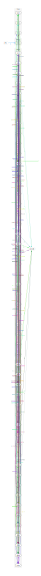

In [188]:
plot_graph(new_gam, size=c(12, 8), align=TRUE, rainbow=TRUE,
               fontsize=15, ranksep=1, nodesep=1, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
           splines='line'
          )

# Expectations

In [189]:
plot_sfs <- function(graph, rewards) {
    sfs <- apply(rewards, 1, function(x) expectation(graph, x))
    data.frame(
      ton=seq(1,length(sfs)),  
      brlen=sfs
      ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
      geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
          scale_x_continuous(breaks = 1:nrow(rewards)) +
          theme(legend.position = "none") + labs(x='nr descendants') +
          labs(y = "Total branch length", x = "Number of descendants") +
          despine
}

get_exp_mat <- function(graph, rewards, s) 
{
    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index_two_locus(s, i, j), ])
      }
    } 
    return(exp_mat)
}
                 
plot_exp_mat <- function(exp_mat) 
{  
    df <- as.data.frame(exp_mat) #%>% gather()
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))

    limit <- max(abs(df$value)) * c(-1, 1)
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

} 

SFS from original and lumped coalescence graphs:

In [190]:
library(gridExtra)

In [191]:
if (model == "Coalescent") {
    p1 <- plot_sfs(new_graph, new_reward_matrix) 
    p2 <- plot_sfs(graph, reward_matrix) 
    grid.arrange(p1, p2, nrow = 1)
}    

In [192]:
reward_matrix

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,4,3,2,1,0,0,1,2,2,⋯,0,0,0,0,0,0,1,1,0,0
0,0,0,0,0,0,1,1,1,0,⋯,0,0,0,2,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,1,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,1,0
0,4,3,2,1,0,2,3,4,3,⋯,0,1,1,0,0,0,0,0,0,0
0,0,1,2,3,4,2,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


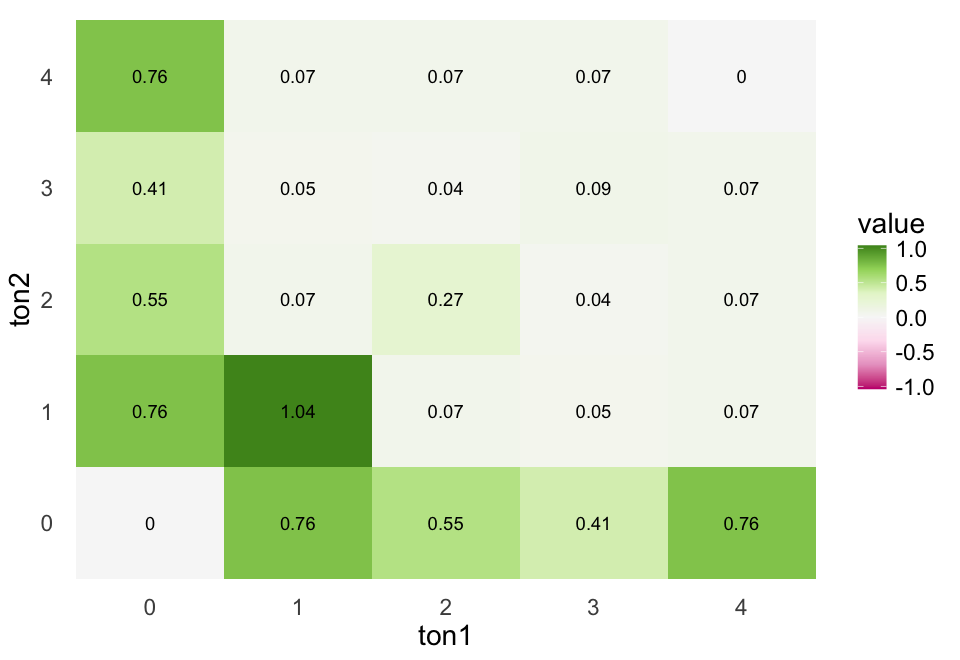

In [193]:
if (model == "ARG") {
    plot_exp_mat(get_exp_mat(graph, reward_matrix, sample_size))    
}

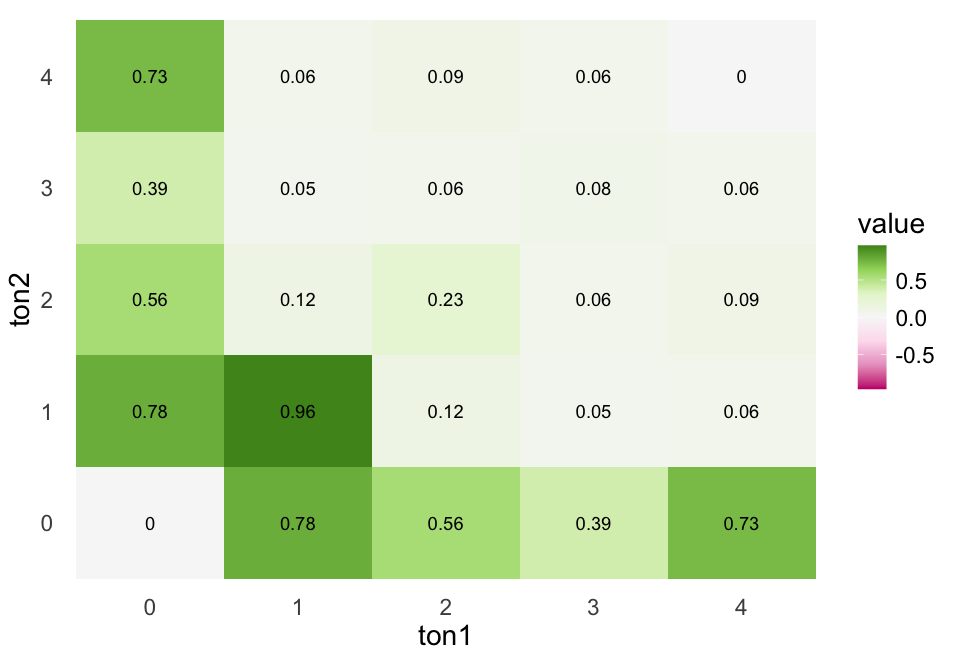

In [194]:
if (model == "ARG") {
    plot_exp_mat(get_exp_mat(new_graph, rbind(0, new_reward_matrix, 0), sample_size))    
}

In [106]:
vertices_length(graph)
apply(reward_matrix, 1, function(x) expectation(graph, x))
sum(apply(reward_matrix, 1, function(x) expectation(graph, x)))   

[1] 110

[1] 0.00000000 0.40540429 0.28918780 0.24308980 0.27416225 0.40540429
 [7] 1.41786262 0.05238377 0.05043808 0.07391124 0.28918780 0.05238377
[13] 0.54900092 0.03744575 0.07198176 0.24308980 0.05043808 0.03744575
[19] 0.24660374 0.08908930 0.27416225 0.07391124 0.07198176 0.08908930
[25] 0.00000000

[1] 5.387655

In [107]:
vertices_length(new_graph)
apply(new_reward_matrix, 1, function(x) expectation(new_graph, x))
sum(apply(new_reward_matrix, 1, function(x) expectation(new_graph, x)))      

[1] 58

[1] 0.47662520 0.30378620 0.19737634 0.26276799 0.47662520 1.31639423
 [7] 0.09492935 0.03908443 0.05382773 0.30378620 0.09492935 0.47646096
[13] 0.07269254 0.09040908 0.19737634 0.03908443 0.07269254 0.25772605
[19] 0.08064824 0.26276799 0.05382773 0.09040908 0.08064824

[1] 5.394875

# Block coalescent and rewards derived from full graph

In [265]:
state_mapping_callback <- function(state) {
    block_state <- c(sum(state))
    return(block_state)
}

rate_mapping_callback <- function(state, child_state) {
    rate <- state[1] * (state[1] - 1) / 2
    return(rate)
}

n <- 4
graph <- standard_coalescent(n) 
state_vector_length <- n

reward_list <- list()

block_state_vector_length <- 1
block_graph <- create_graph(block_state_vector_length)

for (i in 1:vertices_length(graph)) {

    vertex <- vertex_at(graph, i)
    state <- vertex$state

    if (i == 1) {
        block_vertex <- vertex_at(block_graph, 1)
    } else {
        block_state <- state_mapping_callback(state)
        block_vertex <- find_or_create_vertex(block_graph, block_state)
    }

    for (edge in edges(vertex)) {
        child_state <- edge$child$state
        block_child_state <- state_mapping_callback(child_state)
        block_child_vertex <- find_or_create_vertex(block_graph, block_child_state)

        added_reward <- edge$weight * child_state
        reward_list[[block_child_vertex$index]] <- tryCatch(reward_list[[block_child_vertex$index]], error=function(e) {0}) + added_reward

        is_child <- FALSE
        for (block_edge in edges(block_vertex)) {

            if (block_edge$child$index == block_child_vertex$index) {
                is_child <- TRUE
                break
            }
        }
        if (is_child) {
            next
        }
        
        if (i == 1)
            block_rate <- 1
        else
            block_rate <- rate_mapping_callback(block_state, block_child_state)

        add_edge(
          block_vertex,
          block_child_vertex,
          block_rate
          # edge$weight
        )

    }
}
#reward_list[[1]] <- rep(0, state_vector_length)

#reward_list

reward_matrix <- do.call(cbind, reward_list)
reward_matrix <- t(t(reward_matrix)/colSums(reward_matrix)*n:1)

reward_matrix <- cbind(rep(0, nrow(reward_matrix)), reward_matrix)
#reward_matrix <- rbind(rep(0, ncol(reward_matrix)), reward_matrix)

reward_matrix

0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0
0,0,0,0.0000000,1


In [91]:
apply(reward_matrix, 1, function(x) expectation(block_graph, x))

[1] 2.0000000 1.0000000 0.6666667 0.0000000

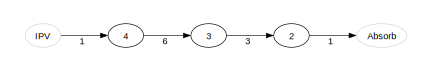

In [92]:
plot_graph(graph_as_matrix(block_graph), fontsize=14, ranksep=1, nodesep=0.25)

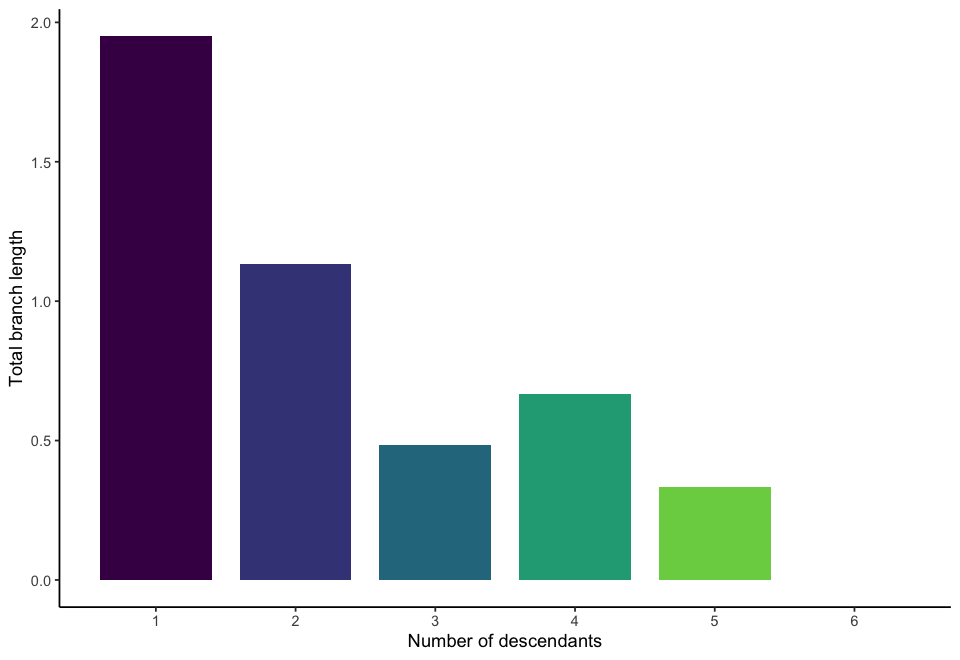

In [89]:
plot_sfs(block_graph, reward_matrix) 

## Same in Cpp

In [16]:
Rcpp::sourceCpp("./cpp/reward_zip.cpp")

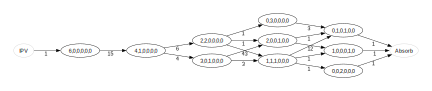

In [17]:
n <- 6
graph <- standard_coalescent(n)
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

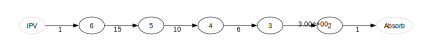

In [18]:
callback <- function(x) {
    return(sum(x))
}
zipped <- reward_zip(graph, callback)
plot_graph(graph_as_matrix(zipped$graph), fontsize=14, ranksep=1, nodesep=0.25)

In [19]:
zipped$rewards

0,6,4,2.4,1.2,0.4,0
0,0,1,1.2,0.9,0.4,0
0,0,0,0.4,0.6,0.4,0
0,0,0,0.0,0.3,0.4,0
0,0,0,0.0,0.0,0.4,0
0,0,0,0.0,0.0,0.0,1


In [20]:
apply(zipped$rewards, 1, function(x) expectation(zipped$graph, x))

[1] 2.0000000 1.0000000 0.6666667 0.5000000 0.4000000 0.0000000

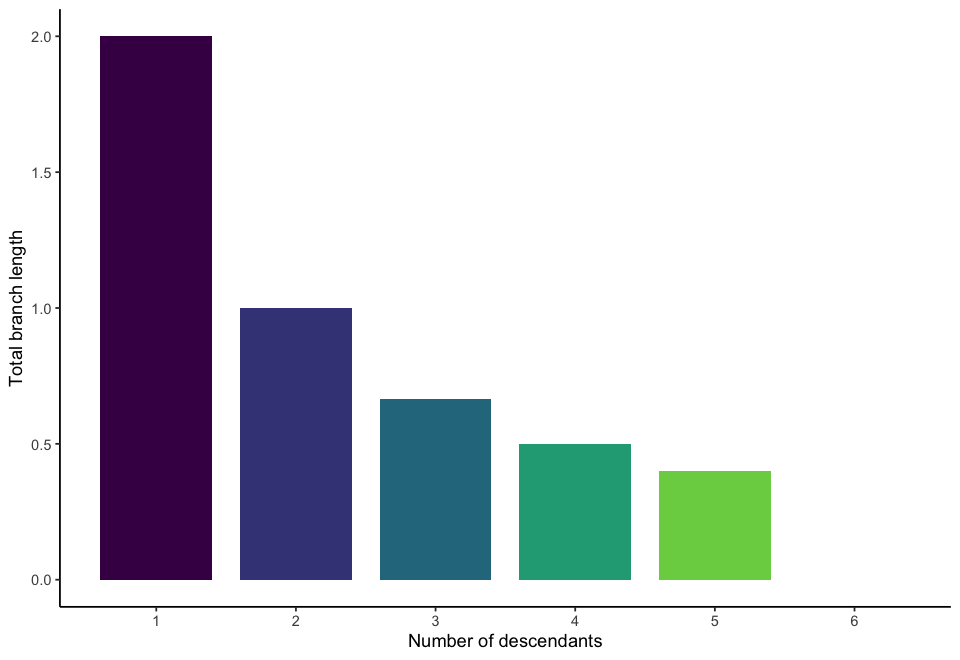

In [21]:
plot_sfs(zipped$graph, zipped$rewards) 


# Block coalescent

In [22]:
block_coalescent <- function(n) {
      
    state_vector_length <- 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(0)
    initial_state[1] <- n
    add_edge(starting_vertex, create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] == 1) {
        break
      }
      rate <- state[1] * (state[1] - 1) / 2
      child_state <- state
      child_state[1] <- child_state[1] - 1
      add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
      index <- index + 1
    }
    return(graph)
}

## SFS rewards for block coalescent

In [209]:
install.packages("partitions")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [190]:
library("partitions")

# equivalence_classes <- function(n) {
#     p <- parts(n)
#     return(apply(p, 2, function(x) {x[x!=0]}))
# }

equivalence_classes <- function(n, size=0) {
    if (size != 0) {    
        m <- apply(parts(n), 2, function(x) {x[x!=0]})
        p <- m[lapply(m, length) == size]
    } else {
        p <- apply(parts(n), 2, function(x) {x[x!=0]})
    }
    return(p)
}

ton_counts <- function(p, n) {
    result <- rep(0, n)
    counts <- table(p)
    for (i in seq(n)) {
        c <- counts[names(counts)==i]
        if (length(c)) {
            result[i] <- c
        }
    }
    return(result)
}

multinom <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom(params[-length(params)]))
}

get_single_locus_block_rewards <- function(n, l) {
    # a column in the matrix computed by get_block_rewards
    rewards <- matrix(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        rewards <- rewards + counts * multinom(counts)
    }
    rewards <- rewards[-length(rewards)]
    if (sum(rewards) > 0) {
        scale <- l/sum(rewards)
        rewards <- rewards * scale
    }
    rewards <- c(0, rewards)
    return(matrix(rewards))
}
get_single_locus_block_rewards(5, 3)

0.0
1.5
1.0
0.5
0.0


In [25]:
n <- 4
graph <- block_coalescent(n)
gam <- graph_as_matrix(graph)

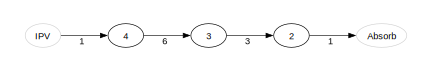

In [26]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [27]:
nr_tons <- n # number of different tons incl the mrca at the absorbing state
tensor_dims <- c(nr_tons, vertices_length(graph)) # one col for each lumped state and one row for each ton

reward_fun <- get_single_locus_block_rewards

reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
rewards

0,0,0,0.0000000,0
0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0


In [28]:
expectation(graph, rewards[4, ])

[1] 0.6666667

In [29]:
# coalescent_reward_matrix <- function(n) {
#     rewards <- matrix(0, n, n)
#     for (p in equivalence_classes(n)) {
#         counts <- ton_counts(p, n)
#         rewards[length(p), ] <- rewards[length(p), ] + counts * multinom(counts)
#     }
#     rewards <- rewards[-1, -ncol(rewards)]
#     if (n == 2) {
#         stopifnot(0, "NOT IMPLEMENTED")
#         scale <- 2/sum(rewards)
#         rewards <- rewards * scale
#         rewards <- c(0, rewards, 0)
#     } else {
#         scale <- (2:n)/apply(rewards, 1, sum)
#         rewards <- rewards * scale
#         rewards <- t(rewards)[, ncol(rewards):1]
#         rewards <- cbind(rep(0, nrow(rewards)), rewards, rep(0, nrow(rewards)))
#     }
#     return(rewards)        
# }
# rewards <- coalescent_reward_matrix(5)
# print(rewards)
# expectation(graph, rewards[3, ])

## Precompute and cache as HDF5

Precompute rewards for a range of sample sizes:

In [112]:
# to_delete <- c()#70:80
# if (length(to_delete) > 0) {
#     h5f <- H5Fopen("../coal_block_rewards.h5")
#     for (sample_size in to_delete) {
#         name <- paste("coalescent/", sample_size, sep="")
#         if (H5Lexists(h5f, name)) {
#             h5delete(h5f, name=name)                          
#         }
#     }
#     H5Fclose(h5f)
# }

In [113]:
reward_fun <- get_single_locus_block_rewards

coal_block_rewards_h5_file <- "../coal_block_rewards.h5"
if (!file.exists(coal_block_rewards_h5_file)) {
    h5createFile(coal_block_rewards_h5_file)
    h5createGroup(coal_block_rewards_h5_file, "coalescent")
}
h5f <- H5Fopen(coal_block_rewards_file)
for (sample_size in 50:100) {
    name <- paste("coalescent/", sample_size, sep="")
    if (H5Lexists(h5f, name)) {
        next
    }
    graph <- block_coalescent(sample_size)
    # tensor_dims <- c(sample_size, vertices_length(graph))    
    reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
    rewards <- array(unlist(reward_list), dim=c(sample_size, vertices_length(graph)))
    # h5delete(h5f, name = paste("coalescent/", sample_size, sep=""))                          
    h5write(rewards, h5f,
            # file="block_coal_rewards.h5", 
            name=paste("coalescent/", sample_size, sep=""))
    # print(sample_size)
    # flush.console()
}
H5Fclose(h5f)
#h5closeAll()

ERROR: Error in h5createFile(coal_block_rewards_h5_file): could not find function "h5createFile"


In [ ]:
rewards <- h5read("../coal_block_rewards.h5", name=paste("coalescent/", sample_size, sep=""))
sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
                         

## Cached computation of SFS

In [339]:
# library(parallel)

# redo_sfs_rewards <- TRUE

# if (redo_sfs_rewards) {
#     v <- 3:20
#     n_list <- as.list(v)
#     names(n_list) <- v
#     sfs_rewards <- mclapply(n_list, coalescent_reward_matrix, mc.cores=detectCores())
#     saveRDS(sfs_rewards, file="sfs_rewards.RData")
# } else {
#     sfs_rewards <- readRDS(file="sfs_rewards.RData")
# }
# rewards <- sfs_rewards[[as.character(n)]]
# sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
# sfs_expectation

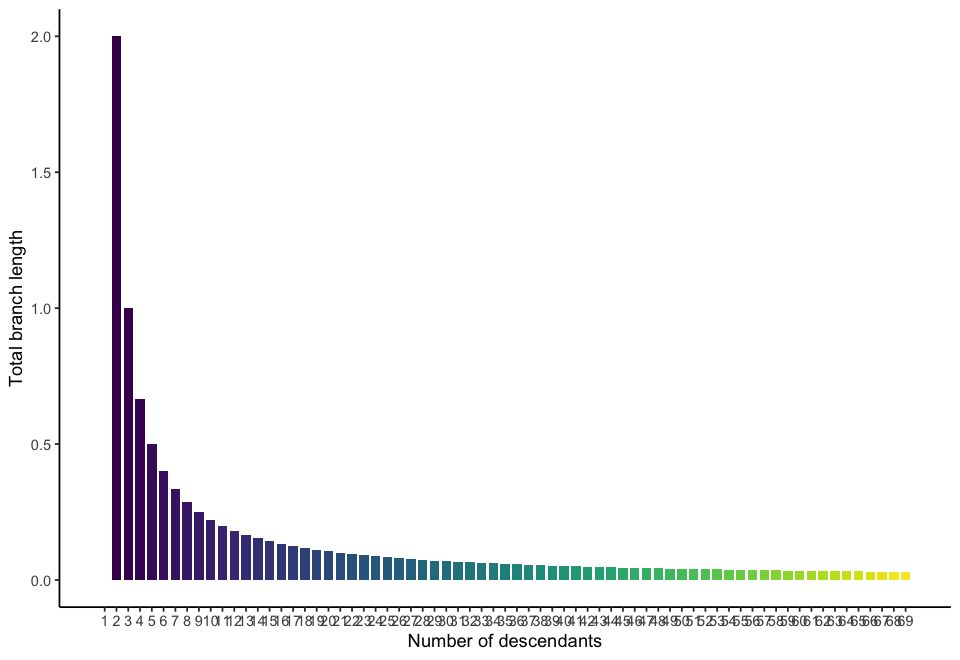

In [20]:
sfs_rewards <- function(graph, sample_size) {
    name <- paste("coalescent/", sample_size, sep="")
    h5f <- H5Fopen("../data/coal_block_rewards.h5")
    if (H5Lexists(h5f, name)) {
        rewards <- h5read(h5f, name=paste("coalescent/", sample_size, sep=""))
    } else {
        tensor_dims <- c(sample_size, vertices_length(graph))    
        reward_list <- lapply(1:vertices_length(graph), 
                              function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(graph, i)$state))))
        rewards <- array(unlist(reward_list), dim=tensor_dims)
        h5write(rewards, 
                h5f, 
                name=paste("coalescent/", sample_size, sep=""))
    }
    H5Fclose(h5f)                              
    return(rewards)
}

graph <- block_coalescent(69)
rewards <- sfs_rewards(graph, 69)
plot_sfs(graph, rewards)            

Compute the first moments for each "ton" for a number of samples:

In [22]:
nr_moments <- 10
sfs_moments <- data.frame(apply(rewards, 1, function(x) moments(graph, nr_moments, x)))
row.names(sfs_moments) <- 1:nr_moments
names(sfs_moments) <- 1:(sample_size-1)
sfs_moments

,1,2,3,4,5,6,7,8,9,10,⋯,41,42,43,44,45,46,47,48,49,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,2.000000,1.000000,0.66666667,0.500000000,0.400000000,0.3333333333,2.857143e-01,2.500000e-01,2.222222e-01,⋯,5.000000e-02,4.878049e-02,4.761905e-02,4.651163e-02,4.545455e-02,4.444444e-02,4.347826e-02,4.255319e-02,4.166667e-02,4.081633e-02
2,0,4.081633,1.027494,0.46111352,0.262032476,0.169458713,0.1189337618,8.832421e-02,6.836348e-02,5.461423e-02,⋯,4.226279e-03,4.092830e-03,3.969561e-03,3.855632e-03,3.750297e-03,3.652898e-03,3.562851e-03,3.479640e-03,3.402807e-03,3.331945e-03
3,0,8.496460,1.084184,0.33062660,0.143757855,0.075907525,0.0453219777,2.945690e-02,2.037349e-02,1.477712e-02,⋯,5.208405e-04,5.034303e-04,4.875412e-04,4.730187e-04,4.597270e-04,4.475465e-04,4.363716e-04,4.261086e-04,4.166739e-04,4.079933e-04
4,0,18.033302,1.174205,0.24555749,0.082470205,0.035894403,0.0184061176,1.056952e-02,6.594050e-03,4.383002e-03,⋯,8.513741e-05,8.225443e-05,7.963364e-05,7.724592e-05,7.506608e-05,7.307226e-05,7.124541e-05,6.956895e-05,6.802840e-05,6.661115e-05
5,0,39.010818,1.304621,0.18876523,0.049416212,0.017890507,0.0079501967,4.069485e-03,2.310175e-03,1.419308e-03,⋯,1.737890e-05,1.678872e-05,1.625281e-05,1.576494e-05,1.531979e-05,1.491276e-05,1.453989e-05,1.419775e-05,1.388335e-05,1.359411e-05
6,0,85.983026,1.486329,0.15008071,0.030894816,0.009384973,0.0036450771,1.677055e-03,8.733174e-04,4.998269e-04,⋯,4.256236e-06,4.111609e-06,3.980316e-06,3.860817e-06,3.751791e-06,3.652107e-06,3.560790e-06,3.476999e-06,3.400004e-06,3.329170e-06
7,0,193.023121,1.735533,0.12332591,0.020132625,0.005174213,0.0017706619,7.379632e-04,3.551629e-04,1.907220e-04,⋯,1.216077e-06,1.174749e-06,1.137235e-06,1.103091e-06,1.071940e-06,1.043459e-06,1.017369e-06,9.934283e-07,9.714296e-07,9.511915e-07
8,0,441.195704,2.076075,0.10466804,0.013661101,0.002994106,0.0009096739,3.459428e-04,1.549414e-04,7.857818e-05,⋯,3.970869e-07,3.835919e-07,3.713420e-07,3.601930e-07,3.500213e-07,3.407213e-07,3.322020e-07,3.243848e-07,3.172015e-07,3.105931e-07
9,0,1026.455312,2.543065,0.09168929,0.009643381,0.001816084,0.0004934130,1.723864e-04,7.231147e-05,3.484044e-05,⋯,1.458687e-07,1.409113e-07,1.364114e-07,1.323158e-07,1.285793e-07,1.251629e-07,1.220334e-07,1.191617e-07,1.165230e-07,1.140954e-07


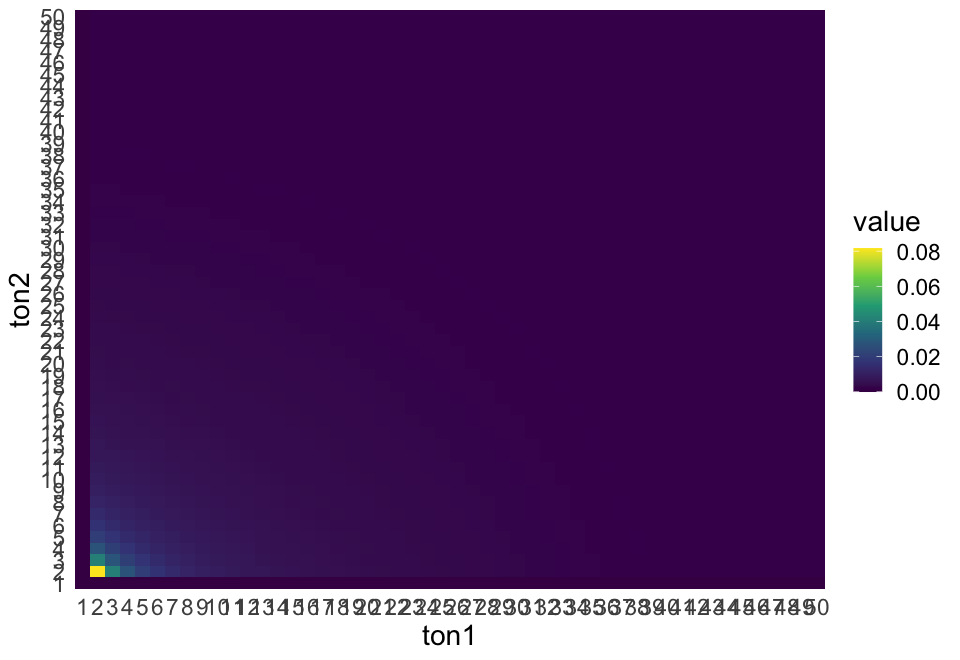

In [23]:
plot_cov_mat(get_cov_mat(graph, rewards))

## Two locus ARG

In [32]:
Rcpp::sourceCpp("./cpp/index_prop_mapping.cpp")

In [338]:
               
construct_arg <- function(s, N, R) {

    # state vector length
    n <- (s+1)**2

    graph <- create_graph(n)
    index <- 1
    # first_vertex <- create_vertex(graph, c(rep(0, s+2), s, rep(0, n-s-3))) # assumes that p=2
    state <- rep(0, n)
    state[props_to_index_two_locus(s, 1, 1, 1)] <- s
    first_vertex <- find_or_create_vertex(graph, state) # assumes that p=2
    add_edge(starting_vertex(graph), first_vertex, 1)

    index <- 2
    while (index <= vertices_length(graph)) {

      vertex <- vertex_at(graph, index)
      state <- vertex$state

      count <- 0
      for (i in 1:n) {
          count <- count + state[i]
      }
      if (count <= 1) {
          # Only one lineage, stop
          index <- index + 1
          next
      }    

      for (i in 1:n) {
        if (state[i] == 0) next

        conf_i <- index_to_props_two_locus(s, i)

        # coalescence #########################
        for (j in i:n) {
          if (state[j] == 0) next
            
          conf_j <- index_to_props_two_locus(s, j)

          if (i == j) {
            if (state[i] < 2) {
              next;
            }
            rate <- state[i] * (state[i] - 1) / 2 / N
          } else {
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            rate <- state[i] * state[j] / N
          }

          child_state <- state
        
          # lineages with index i and j coalesce:  
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          stopifnot(conf_i$descendants_l1+conf_j$descendants_l1 <= s)
          stopifnot(conf_i$descendants_l2+conf_j$descendants_l2 <= s)

          # coalescene into lineage with index k
          k = props_to_index_two_locus(s, conf_i$descendants_l1+conf_j$descendants_l1, conf_i$descendants_l2+conf_j$descendants_l2)
          child_state[k] <- child_state[k] + 1

          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)

        }
        

        # recombination #######################
        if (state[i] > 0 && conf_i$descendants_l1 > 0 && conf_i$descendants_l2 > 0) {

          rate <- R #* state[i] 
          child_state <- state

          # a lineage with index i recombines to produce lineages with index k and l
          k = props_to_index_two_locus(s, conf_i$descendants_l1, 0)
          l = props_to_index_two_locus(s, 0, conf_i$descendants_l2)
          child_state[i] <- child_state[i] - 1
          child_state[k] <- child_state[k] + 1
          child_state[l] <- child_state[l] + 1
            
          child_vertex <- find_or_create_vertex(graph, child_state)
          add_edge(vertex, child_vertex, rate)
        }

      }

      index <- index + 1

      # if ((index %% 50) == 0) {
      #   cat(index, vertices_length(graph), "\n")
      # }

    }
    
    return(graph)
}

In [394]:
sample_size <- 3
N <- 1
R <- 50

In [395]:
map_state <- function(state)
{
    # TODO: sample_size THIS SHOULD BE GIVEN TO THE FUNCTION...
    
    lumped_state <- c(0, 0, 0)
    for (i in 1:length(state)) {
        props <- index_to_props_two_locus(sample_size, i)        
        lumped_state[1] <- lumped_state[1] + state[i] * as.logical(props$descendants_l1)
        lumped_state[2] <- lumped_state[2] + state[i] * as.logical(props$descendants_l2)
        lumped_state[3] <- lumped_state[3] + state[i] * as.logical(props$descendants_l1) * as.logical(props$descendants_l2)
#        lumped_state[3] <- lumped_state[3] + state[i] * min(props$descendants_l1, props$descendants_l2)
    }
    stopifnot(lumped_state[1] >= lumped_state[3])
    stopifnot(lumped_state[2] >= lumped_state[3])    
    return(lumped_state)
}
label_fun <- function(state, index)
{
    return(paste(map_state(state), collapse=""))
}

In [396]:
graph <- construct_arg(sample_size, N, R)
vertices_length(graph)

[1] 32

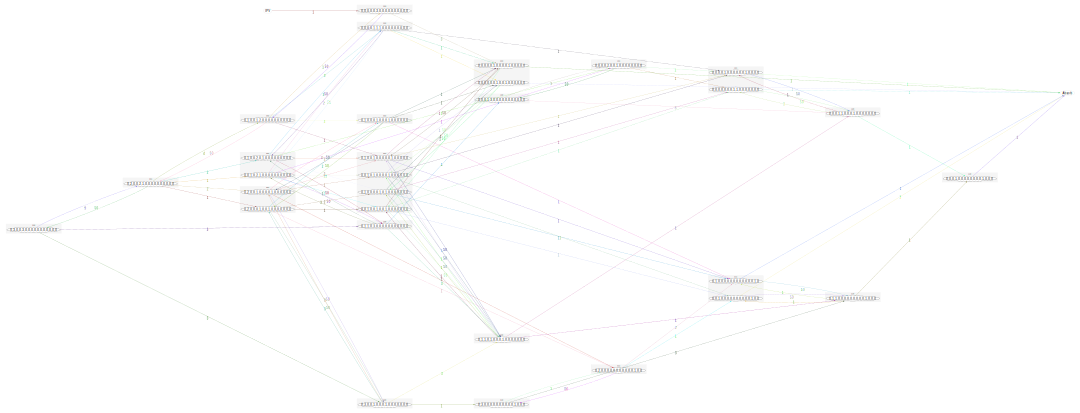

In [406]:
plot_graph(graph_as_matrix(graph), size=c(15, 8), align=TRUE, rainbow=TRUE,
               fontsize=25, ranksep=8, nodesep=1.5, rankdir="LR", subgraphs=TRUE, subgraphfun=label_fun, 
           splines='line'
          )

### Lumped graph

For a sample size of 2 there is no lumping. So this can serve as test to get the same graph back:

In [407]:
Rcpp::sourceCpp("./cpp/reward_zip.cpp")

In [408]:
lumped <- reward_zip(graph, map_state)
vertices_length(lumped$graph)

[1] 24

In [409]:
gam <- graph_as_matrix(graph)
for (i in 1:nrow(gam$states)) {
    cat(gam$states[i, ], ' -> ', map_state(gam$states[i,]), '\n')
}

0 3 0 0 3 0 0 0 0 0 0 0 0 0 0 0  ->  3 3 0 
0 2 0 0 2 1 0 0 0 0 0 0 0 0 0 0  ->  3 3 1 
0 1 0 0 1 2 0 0 0 0 0 0 0 0 0 0  ->  3 3 2 
0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0  ->  3 3 3 
0 0 1 0 2 1 0 0 0 0 0 0 0 0 0 0  ->  2 3 1 
0 1 1 0 3 0 0 0 0 0 0 0 0 0 0 0  ->  2 3 0 
0 1 0 0 2 0 1 0 0 0 0 0 0 0 0 0  ->  2 3 1 
0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0  ->  2 3 2 
0 2 0 0 0 1 0 0 1 0 0 0 0 0 0 0  ->  3 2 1 
0 3 0 0 1 0 0 0 1 0 0 0 0 0 0 0  ->  3 2 0 
0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0  ->  3 2 1 
0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0  ->  3 2 2 
0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0  ->  1 3 0 
0 0 0 0 2 0 0 1 0 0 0 0 0 0 0 0  ->  1 3 1 
0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0  ->  2 2 1 
0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0  ->  2 2 2 
0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0  ->  2 2 1 
0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0  ->  2 2 1 
0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0  ->  2 2 0 
0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0  ->  2 2 1 
0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0  ->  2 2 2 
0 3 0 0 0 0 0 0 0 0 0 0 1 0 0 0  ->  3 1 0 
0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 

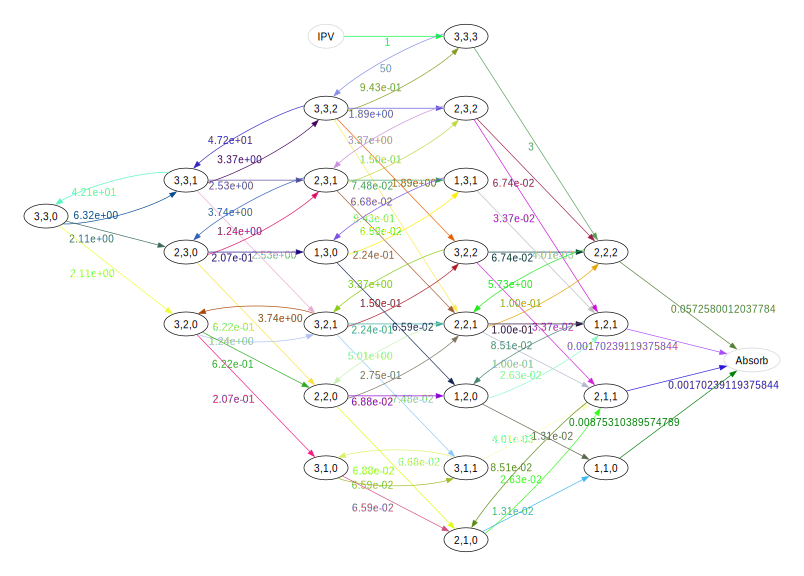

In [410]:
plot_graph(graph_as_matrix(lumped$graph), size=c(15, 8), align=TRUE, rainbow=TRUE,
               fontsize=15, ranksep=2, nodesep=1, rankdir="LR",# subgraphs=TRUE, subgraphfun=label_fun, 
           splines='line'
          )

In [385]:
shared_masks <- function(n, m) {
    t(combn(n, m, function(x) replace(numeric(n),x,1)))
}

get_two_locus_block_rewards <- function(n, nl1, nl2, nlinked) {

    stopifnot(nl1 >= nlinked)
    stopifnot(nl2 >= nlinked)
    
    state_rewards <- matrix(0, n+1, n+1)

    eqsets_l1 <- equivalence_classes(n, size=nl1)
    eqsets_l2 <- equivalence_classes(n, size=nl2)

    for (l1_set in eqsets_l1) {

        l1_ton_counts <- ton_counts(l1_set, n)
        
        for (l2_set in eqsets_l2) {

            l2_ton_counts <- ton_counts(l2_set, n)

            if (nlinked > 0) {
                # linked contributions
                l1_shared_mask <- shared_masks(nl1, nlinked)        
                l2_shared_mask <- shared_masks(nl2, nlinked)            
                for (i in 1:nrow(l1_shared_mask)) {
                    for (j in 1:nrow(l2_shared_mask)) {
                        l1_linked_set <- l1_set * l1_shared_mask[i, ]
                        l2_linked_set <- l2_set * l2_shared_mask[j, ]
                        for (l1_ton in l1_linked_set) {
                            for (l2_ton in l2_linked_set) {
                                if (l1_ton == 0 || l2_ton == 0) {
                                    next
                                }
                                state_rewards[l1_ton+1, l2_ton+1] <- state_rewards[l1_ton+1, l2_ton+1] + 1 * multinom(l1_ton_counts) * multinom(l2_ton_counts)   
                            }
                        }
                    }
                }
                l1_unlinked_set <- l1_set * +(!l1_shared_mask[i, ]) # fliped mask
                l2_unlinked_set <- l2_set * +(!l2_shared_mask[j, ]) # fliped mask
            } else {
                l1_unlinked_set <- l1_set
                l2_unlinked_set <- l2_set                
            }

            # unlinked contributions
            for (l1_ton in l1_unlinked_set) {
                if (l1_ton == 0) {
                    next
                }                
                state_rewards[l1_ton, 1] <- state_rewards[l1_ton, 1] + 1 * multinom(l1_ton_counts)
            }
            for (l2_ton in l2_unlinked_set) {
                if (l2_ton == 0) {
                    next
                }
                state_rewards[1, l2_ton] <- state_rewards[1, l2_ton] + 1 * multinom(l2_ton_counts)
            }
        }
    }
    
    # # FIGURE OUT HOW TO DO THE NORMALIZATION...!      I THINK I NEED THE NORMALIZATION WHEN ADDING INDIVIDUAL CONTRIBUTIONS INSTEAD...
    if (sum(state_rewards) > 0) {
        scale <- (nlinked + nl1-nlinked + nl2-nlinked)/sum(state_rewards) # norm by total linked and unlined live lineages
        state_rewards <- state_rewards * scale
    }

    state_rewards <- matrix(c(0, c(state_rewards)))

    return(state_rewards)
}

#get_two_locus_block_rewards(3, 2, 2, 1)

In [361]:
reward_fun <- get_two_locus_block_rewards
nr_tons_combos <- (sample_size+1)^2
# one col for each lumped state and one row for each ton
tensor_dims <- c(nr_tons_combos, vertices_length(lumped$graph)) 
#tensor_dims
reward_list <- lapply(
    1:vertices_length(lumped$graph), # MAYBE USE 2 BERE TO SKIP STARTING STATE??///
    function(i) do.call(reward_fun, as.list(c(sample_size, vertex_at(lumped$graph, i)$state)))
)
lumped_rewards <- array(unlist(reward_list), dim=tensor_dims)
# lumped_rewards <- cbind(0, lumped_rewards)
#lumped_rewards

In [362]:
get_exp_mat <- function(graph, rewards, s) 
{
    exp_mat <- matrix(nrow=s+1,ncol=s+1)
    for (i in 0:s) {
      for (j in 0:s) {
        exp_mat[i+1,j+1] <- expectation(graph, rewards[props_to_index_two_locus(s, i, j),])
      }
    } 
    return(exp_mat)
}
plot_exp_mat <- function(exp_mat) 
{  
    df <- as.data.frame(exp_mat) #%>% gather()
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))

    limit <- max(abs(df$value)) * c(-1, 1)
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
     theme(panel.grid.major = element_blank(), 
            panel.grid.minor = element_blank(), 
            text=element_text(size=17))

}

0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,1,0,1,0,0,1,2,⋯,1,0,1,0,1,2,3,0,0,3
0,0,0,0,0,0,1,0,0,0,⋯,1,1,0,0,1,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,1,0
0,0,0,1,0,1,0,1,0,2,⋯,0,1,0,2,3,0,1,0,3,0
0,3,1,2,0,0,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,1,0,0,⋯,0,0,1,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
0,0,0,0,0,0,1,0,0,0,⋯,0,0,1,0,0,0,1,0,0,0
0,0,0,0,0,0,0,0,1,0,⋯,0,1,0,0,0,0,0,0,0,0
0,0,1,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


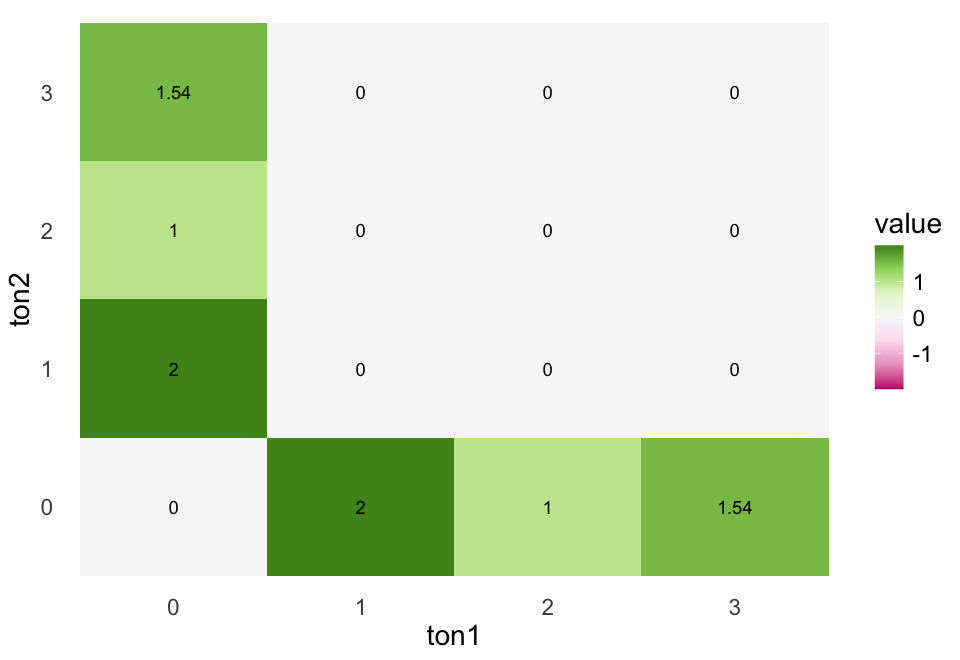

In [363]:
rewards <- t(states(graph))
rewards
plot_exp_mat(get_exp_mat(graph, rewards, sample_size))

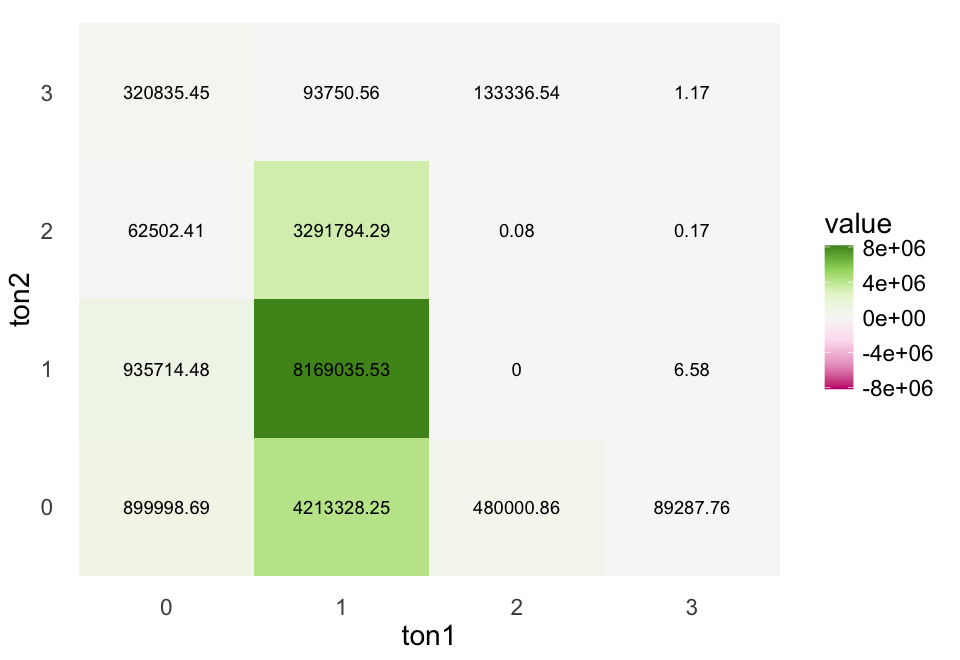

In [364]:
exp_mat <- matrix(apply(lumped_rewards, 1, function (r) expectation(lumped$graph, r)), sample_size+1, byrow=FALSE)
plot_exp_mat(exp_mat)

In [373]:
exp_mat <- matrix(nrow=sample_size+1,ncol=sample_size+1)
for (i in 1:(sample_size+1)) {
  for (j in 1:(sample_size+1)) {
      print(i^2+j)
      print(expectation(lumped$graph, lumped_rewards[i^2+j,]))
    exp_mat[i+1,j+1] <- expectation(lumped$graph, lumped_rewards[i^2+j,])
  }
} 
plot_exp_mat(exp_mat)

[1] 2
[1] 0.3308824
[1] 3
[1] 0.1323529
[1] 4
[1] 0.02205882


ERROR: Error in `[<-`(`*tmp*`, i + 1, j + 1, value = expectation(lumped$graph, : subscript out of bounds


In [ ]:

            # loop all combinations of nlinked shared ones from l1_set and 
                       
            
            # # there need to be at least nlinked shared numbers between l1_set and l2_set
            # l1_l2_set_intersection <- intersect(l1_set, l2_set)           
            # if (nlinked > length(l1_l2_set_intersection)) {
            #     next
            # }
            
            # # loop all combinations of nlinked shared ones
            # for (linked_set in combn(l1_l2_set_intersection, nlinked, simplify = FALSE)) {
            #     # linked class must be subset of classes shared between loci
            #     # if (!setequal(intersect(linkcl,shared_classes), linkcl)) {
            #     if (!all(linked_set %in% l1_l2_set_intersection)) {  
            #         next
            #     }
            #     linked_tons <- ton_counts(linked_set, n)


            #     for (l1_eqrel in l1_set) {
            #         if (l1_eqrel
            #     }
            #     for (l2_eqrel in l2_set) {

            #     }        


                
            #     # add reward contribution from shared
            #     # add shared ton counts to diagonal
            #     diag(state_rewards) <- diag(state_rewards) + linked_tons * multinom(linked_tons) #  CHECK THIS...

            #     # remove shared from l1_set
            #     l1_set_unlinked <- l1_set[-match(l1_l2_set_intersection, l1_set)]
            #     l1_unlinked_tons <- ton_counts(l1_set_unlinked, n)
            #     # add ton counts to all cols
            #     state_rewards <- state_rewards + matrix(rep(l1_unlinked_tons, n), n) * multinom(l1_unlinked_tons) #  CHECK THIS...

            #     # remove shared from l1_set
            #     l2_set_unlinked <- l2_set[-match(l1_l2_set_intersection, l2_set)]
            #     l2_unlinked_tons <- ton_counts(l2_set_unlinked, n)
            #     # add ton counts to all rows
            #     state_rewards <- state_rewards + matrix(rep(l2_unlinked_tons, n), n, byrow=TRUE) * multinom(l1_unlinked_tons) #  CHECK THIS...
                    
            # }

# ARG

## Block ARG in R

In [76]:
block_arg <- function(n, rho=1) {
      
    state_vector_length <- 4
    # state_vector_length <- 3
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(n, n, n, 0)
    # initial_state <- c(n, n, n)
    add_edge(starting_vertex, find_or_create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state

        
      if (state[1] <= 1 && state[2] <= 1 && (state[3] == 1 ) ) {
      # if (state[1] <= 1 && state[2] <= 1) {
        index <- index + 1 
        next
      }

     # PROBLEM: WE KEEP TRACK OF HOW MANY THAT HAVE LINKED BACK TOGETHER, 
     # BUT NOT IF THESE HAVE LINKED APART AGAIN, SO WE DO NOT HAVE A WAY TO 
     # TO DETERMINE IF THE LAST TWO L1 AND L2 ARE LINKED OR NOT...
        # but we know from the ratio og coal rate and rec rate what proportion
        # of the time that they are...

        
      l1 <- state[1] - state[3]
      l2 <- state[2] - state[3]
      l1l2 <- state[3]
      l1_l2 <- state[4]
      # prop_sample_linked <- state[4] / n

      if (l1 >= 1) {
        if (l1 >= 2 || l1l2 >= 1) {
            rate <- (l1 * (l1 - 1) / 2) + l1*l1l2
            child_state <- state
            child_state[1] <- child_state[1] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }
      if (l2 >= 1) {
        if (l2 >= 2 || l1l2 >= 1) {
            rate <- (l2 * (l2 - 1) / 2) + l2*l1l2
            child_state <- state
            child_state[2] <- child_state[2] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }         
      if (l1-l1_l2 >= 1 && l2-l1_l2 >= 1) { # THE ONES ARE NEITHER LINKED OR RELINKED
        rate <- l1 * l2
        child_state <- state
        child_state[4] <- child_state[4] + 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)   
      }
      if (l1l2 >=2) {
        rate <- l1l2 * (l1l2 - 1) / 2
        child_state <- state
        child_state[1] <- child_state[1] - 1
        child_state[2] <- child_state[2] - 1
        child_state[3] <- child_state[3] - 1          
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }        

      # recombination
      if (l1l2 >=1) {        
        rate <- rho        # hardcoded recombination rate
        child_state <- state
        child_state[3] <- child_state[3] - 1
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }

      index <- index + 1 
    }
    return(graph)
}

n <- 2
graph <- block_arg(n, rho=5)
vertices_length(graph)

[1] 22

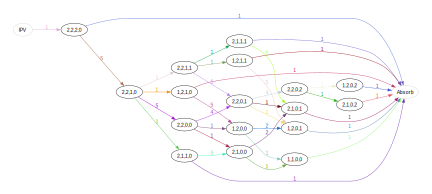

In [77]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, rainbow=TRUE)

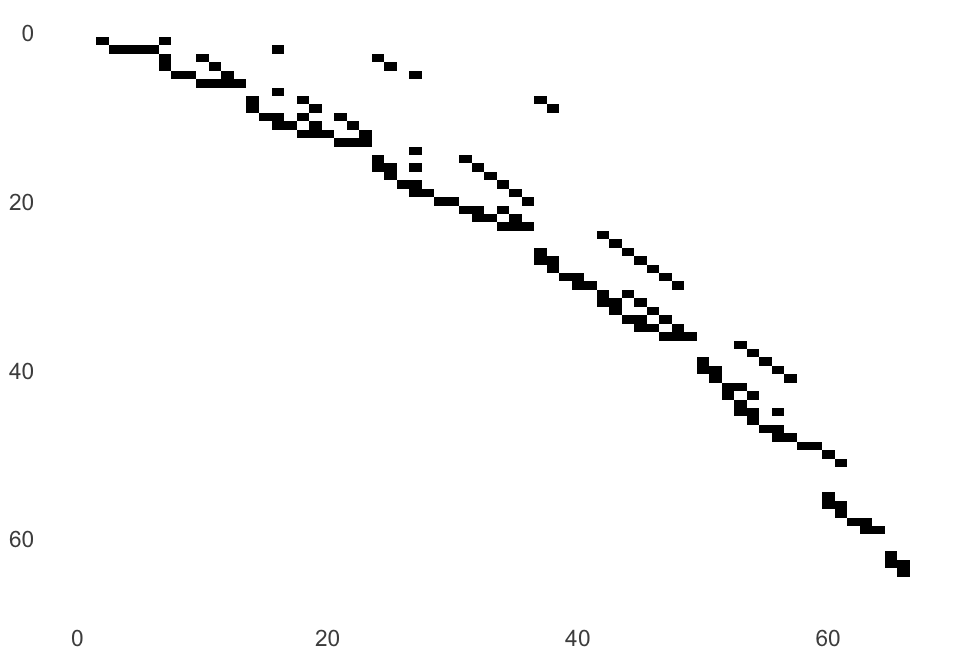

In [45]:
plot_sim <- function(graph)
{
    gam <- graph_as_matrix(graph)
    mat <- t(gam$SIM)
    mat <- matrix(as.integer(mat > 0), dim(mat))
    
    rownames(mat) <- 1:nrow(mat)
    colnames(mat) <- 1:ncol(mat)
    df <- as.data.frame(mat)
    df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
    df$n <- as.numeric(df$n)
    df$m <- as.numeric(df$m)
    ggplot(df, aes(n, m)) +
        geom_tile(aes(fill = value), show.legend = FALSE) + 
        scale_y_reverse() +
        scale_fill_gradient(low="white", high="black") +
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              text=element_text(size=17))
}

plot_sim(graph)

## 2D SFS rewards for block ARG

In [55]:
# get_block_rewards <- function(n, l) {
#     # a column in the matrix computed by get_block_rewards
#     rewards <- matrix(0, n)
#     for (p in equivalence_classes(n, size=l)) {
#         counts <- ton_counts(p, n)
#         rewards = rewards + counts * multinom(counts)
#     }

#     rewards <- rewards[-length(rewards)]
#     if (sum(rewards) > 0) {
#         scale <- l/sum(rewards)
#         rewards <- rewards * scale
#     }
#     rewards <- c(0, rewards)
#     return(matrix(rewards))
# }
# get_block_rewards(5, 3)

marg_tree_rewards <- function(n, l) {
    r <- rep(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        r <- r + counts * multinom(counts)
    }
    scale <- l / sum(r)
    r <- r * scale
    return(r)
}

          
# arg_state_reward <- function(n, locus1, locus2, linked, orig_linked) {
arg_state_reward <- function(n, locus1, locus2, linked, relinked) {

    l1 <- locus1 - linked
    l2 <- locus2 - linked

    rewards <- matrix(0, n+1, n+1)
    if (locus1 + locus2 == 0) {
        return(rewards)
    }
    part <- equivalence_classes(n, size=linked)
    print(part)
    for (l1_p in part) {
        for (l2_p in part) {
            for (a in l1_p) {
                for (b in l2_p) {
                    if (locus1 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l1_p, n)) 
                    if (locus2 > 0)
                        rewards[a+1, b+1] <- rewards[a+1, b+1] + (1 - (linked / locus1)) * multinom(ton_counts(l2_p, n)) 

                        # (1 - orig_linked/n) * multinom(ton_counts(l1_p, n)) + 
                        # (1 - orig_linked/n) * multinom(ton_counts(l2_p, n)) 
                }
            }
        }
    }
    print(rewards)
    for (i in 1:length(part)) {
        p <- part[i][[1]]
        for (a in p) {
            if (locus1 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus1) * multinom(ton_counts(p, n))
            if (locus2 > 0)
                rewards[a+1, a+1] <- rewards[a+1, a+1] + (linked / locus2) * multinom(ton_counts(p, n))

                # (orig_linked/n) * multinom(ton_counts(p, n)) + 
                # (orig_linked/n) * multinom(ton_counts(p, n)) 
        }
    }
#print(rewards)
    # top_row = colSums(rewards)
    # left_col = rowSums(rewards)
    
    rewards[n+1, n+1] = 0

    if (sum(rewards) > 0) {
        scale <- linked / sum(rewards)
        rewards <- rewards * scale
    }
    
    if (l1 > 0) {
        rewards[1, ] <- rewards[1, ] + c(0, marg_tree_rewards(n, l1) )
        # rewards[1, ] <- top_row
    }
    if (l2 > 0) {
        rewards[, 1] <- rewards[, 1] + c(0, marg_tree_rewards(n, l2) )
        # rewards[, 1] <- left_col
    }


    
    return(rewards)
}

# IT SEEMS WE DO NOT GET VALUES IN THE LINKED PART OF THE MATRIX IF NR LINKED IS ONE... 

# arg_state_reward(3, 3, 0, 0)
# #arg_state_reward(3, 3, 1, 0)

In [69]:
n = 4
graph <- block_arg(n, rho=5000)

tensor_dims <- c((n+1), (n+1), vertices_length(graph))
reward_fun <- arg_state_reward
reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
#print(dim(rewards))
expectation(graph, rewards[4, 4, ])

[[1]]
[1] 1 1 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 2 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 2 1 1

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0  0.0    0    0
[2,]    0    6  3.0    0    0
[3,]    0    3  1.5    0    0
[4,]    0    0  0.0    0    0
[5,]    0    0  0.0    0    0
[[1]]
[1] 3 1

[[2]]
[1] 2 2

     [,1] [,2] [,3] [,4] [,5]
[1,]    0    0    0    0    0
[2,]    0    0    0    0    0
[3,]    0    0    0    0    0
[4,]    0    0    0    0    0
[5,]    0    0    0    0    0
[[1]]
[1] 3 1

[[2]]
[1] 2 2

     [,1]     [,2]     [,3]     [,4] [,5]
[1,]    0 0.000000 0.000000 0.000000    0
[2,]    0 1.333333 2.000000 1.333333    0
[3,]    0 2.000000 2.666667 2.000000    0

[1] 5.336755e-05

In [70]:
exp_mat <- matrix(0, nrow=n+1,ncol=n+1)
for (i in 1:(n+1)) {
  for (j in 1:(n+1)) {
    exp_mat[i,j] <- expectation(graph, rewards[i, j, ])
  }
} 
exp_mat

0.0000000,1.997337e+00,1.000331e+00,6.668002e-01,0.5559003
1.9973372,1.185665e-03,1.064734e-04,2.664637e-05,0.0000000
1.0003305,1.064734e-04,2.133901e-04,3.996956e-05,0.0000000
0.6668002,2.664637e-05,3.996956e-05,5.336755e-05,0.0000000
0.5559003,0.000000e+00,0.000000e+00,0.000000e+00,0.0000000


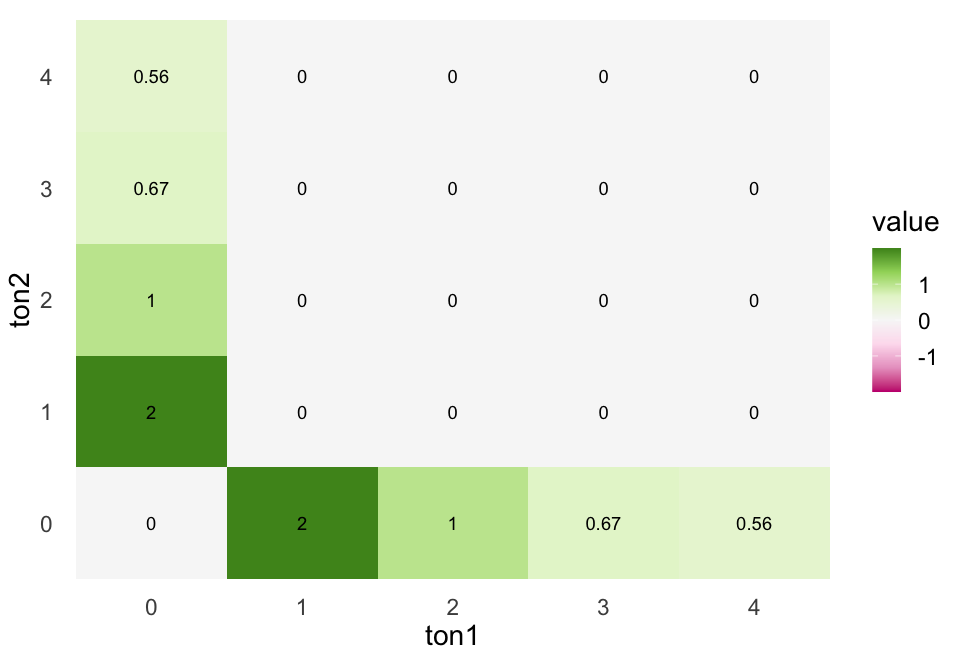

In [71]:
df <- as.data.frame(exp_mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
limit <- max(na.omit(abs(df$value))) * c(-1, 1)
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
    theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

In [68]:
exp_mat[, 1] / sum(exp_mat[, 1])

[1] 0.0000000 0.2930616 0.2432806 0.2030296 0.2606282

In [516]:
exp_mat[1, ] / exp_mat[, 1]

[1] NaN   1   1   1   1   1

Marginal SFSs:

In [36]:
x <- colSums(exp_mat)
sfs_locus1 <- x[c(-1, -length(x))]
x <- rowSums(exp_mat)
sfs_locus2 <- x[c(-1, -length(x))]

Fits expectations for a single locus:

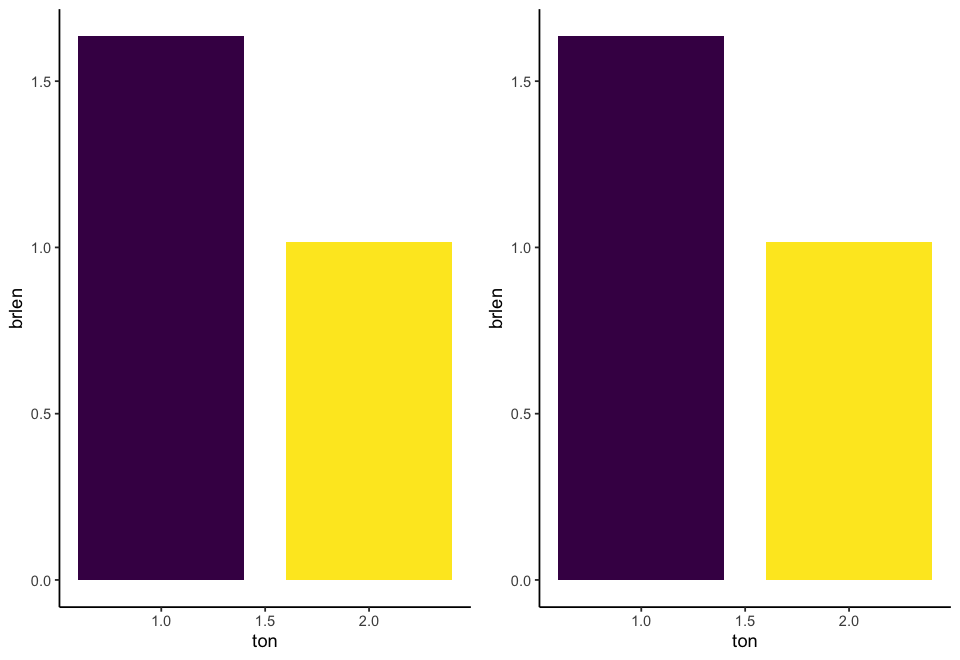

In [37]:
grid.arrange(
    data.frame(
      ton=seq(1,length(sfs_locus1)),  
      brlen=sfs_locus1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs_locus2)),  
      brlen=sfs_locus2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    nrow = 1)
